In [49]:
import sqlite3 as sql
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from itertools import combinations

from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

import plotly.graph_objs as go
import plotly.plotly as py
from plotly.graph_objs import *

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline


In [50]:
df = pd.read_csv('./database.sqlite')

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



- CASEID - case number
- DOF1 - direction of force (highest)
- GAD1 - deformation location (highest)
- PSU - primary sampling unit number
- YEAR - calender year of crash
- STRATIF - case stratum
- BODYTYPE - vehicle body type
- DVEST - estimated highest delta V
- DVBASIS - basis for total deltav V (highest)
- DVTOTAL - total delta V
- MAKE - vehicle make
- MODELYR - vehicle model year
- AGE - age of occupant
- BAGAVAIL - air bag system availability
- BAGDEPLY - air bag system deployed
- BAGFAIL - air bag system failure
- CASENO - case sequence number
- CHTYPE - type of child safety seat
- DEATH - time of death
- HEIGHT - height of occupent
- HOPSTAY - hospital stay
- INJSEV - injury severity (police rating)
- MANAVAIL -
- MANFAIL - 
- MANUSE - manual belt system use 
- OCCNO - occupant number
- ROLE - occupant's role
- SEATPOS - occupant's seat position
- SEX - occupant's sex
- TREATMENT - treatment - mortality
- WEIGHT - occupant's weight

In [51]:
fatal = df.copy()

In [52]:
fatal.shape

(2716427, 32)

In [53]:
# changing all columns to lower case
columns = fatal.columns
columns_lower = []
for col in columns:
    columns_lower.append(col.lower())
fatal.columns = columns_lower

In [54]:
## removed unnamed: 0 column since it matched the index
fatal.drop(labels='unnamed: 0',axis=1,inplace=True)

In [55]:
# dictionay of categorie ID's (named how they will appear when get dummies is applied)
dvest = {'dvest_0':'reconstructed_dv','dvest_1':'dv<10kmph','dvest_2':'10 >= dv < 25kmph','dvest_3':'25 >= dv < 40kmph',
         'divest_4':'40 >= dv <55kmph','divest_5':'dv >= 55kmph','divest_6':'minor damage','divest_7':'moderat damage',
         'divest_8':'severe damage'}

dvbasis = {'dvbasis_0':'not_ispctd','dvbasis_1':'S_dmg_only','dvbasis_2':'S_dmg_&_trjctry','dvbasis_3':'S_missing_vhcl', 
           'dvbasis_4':'S_dmg_cdc_only', 'dvbasis_5':'one_vhcle_byond_S_scope','dvbasis_6':'rollover',
           'dvbasis_7':'non_hrzntl_forces','dvbasis_8':'sideswipe_dmg','dvbasis_9':'severe_override',
          'dvbasis_10':'ylding_objct','dvbasis_11':'overlapping_dmg','dvbasis_12':'insuf_data',
           'dvbasis_98':'other','dvbasis_99':'unknown'}

gad1 = {'gad1_F':'front','gad1_L':'left','gad_R':'right','gad1_B':'back','gad1_uk':'unkown','gad1_T':'top',
        'gad1_U':'undercarriage'}


bagavail = {'bagavail_1':'no','bagavail_2':'yes','bagavail_3':'unknown'}
# stratif = {'stratif_k':'fatality','stratif_F':'injry_no_tow_hsptl',
#           'stratif_E':'injry_tow','stratif_C':'two_tow_no_hsptl','stratif_D':}
# air bad deployed 
bagdeply = {'bagdeply_0':'no_bag', 'bagdeply_1':'impct_deply','bagdeply_3':'deply_ukdetls',
            'bagdeply_5':'uk_deply','bagdeply_7':'no_deply'}

# air bag failure
bagfail = {'bagfail_0':'no_bag','bagfail_1':'no','bagfail_2':'yes'}

# child seat type
chtype = {'chtype chtype _0':'none','chtype_1':'conv_seat','chtype_2':'frwd_face','chtype_3':'infnt_seat',
          'chtype_4':'boost_seat','chtype_7':'vest','chtype_8':'harness'}

# Injury severity
injsev = {'injsev_0':'no_inj','injsev_1':'pssbl_inj','injsev_2':'n_incptng_inj','injsev_3':'incptng_inj',
          'injsev_4':'killed','injsev_5':'inj_sev_uk','injsev_6':'die_b4_crsh'}

# Drop mannavail since it's same data as manuse
# Manual seatbelt used
manuse = {'manuse_0':'none','manuse_1':'inoperative','manuse_2':'shldr_b','manuse_3':'lap_b',
          'manuse_4':'laphshldr_b','manuse_5':'b_avail_uk','manuse_8':'othr_b_use',
          'manuse_12':'shldr_chld_seat','manuse_13':'lap_chld_seat','manuse_14':'lapshldr_chld_seat',
          'manuse_15':'b_chld_seat_uk','manuse_18':'othrb_chld_seat'}

# Manual seatbelt fail
manfail = {'manfail_0':'nouse','manfail_1':'no_mlfctn',
           'manfail_2':'torn_wbbng','manfail_3':'bckl',
           'manfail_4':'uppr_anchr','manfail_5':'othr_anchr',
           'manavail_6':'retrctr','manavail_7':'combo',
           'manfail_8':'other'}

role = {'role_1':'driver','role_2':'passenger'}



In [56]:
# replace 9 with uk for (unknown per the NASS documents)
# fatal['gad1'] = fatal['gad1'].copy().replace('9','uk')

In [57]:
# replace 0 with 1 since they are the same thing according to the NASS documents
fatal['bagavail'] = fatal['bagavail'].copy().replace(0,1,axis=0)

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning:

the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect



In [58]:
# according NASS psu and caseno are same info as caseid and all are not relevant to the scope
fatal.drop(['psu', 'caseno', 'caseid'],axis=1,inplace=True)

In [59]:
# remove manavail since manuse gives the same information
fatal.drop('manavail', axis=1, inplace=True)

In [60]:
# remove bagavail since bagdeply has the same information
fatal.drop('bagavail', axis=1, inplace=True)

In [61]:
#  Remove occno since it's same informaton covered by seatpos
fatal.drop('occno', axis=1, inplace=True)

In [62]:
#  Remove these columns becuase they all conatain the same information as the target
fatal.drop(['death','hospstay','stratif','treatmnt'], axis=1, inplace=True)

In [63]:
# Change 1 to 0
fatal['role'].replace(to_replace=[1,2], value=[0,1], inplace=True, axis=0)

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning:

the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect



In [64]:
# removing 2 from bagfail (only 0.2% of the data and stands for "not available")
fatal = fatal[ fatal['bagfail'].isin([0,1]) ]

In [65]:
# Dictionary of each column's unique values key = counts, value = feature name
unique_dict = {}
for col in fatal.columns:
    unique_dict[col] =  fatal[col].nunique()

# Features <30 counts
categoricals = []
for key in unique_dict.keys():
    if unique_dict[key] < 30:
        categoricals.append(key)

In [66]:
for col in categoricals:
    print(col)
    print(fatal[col].value_counts())

gad1
F    1128361
L     333641
R     263584
B     255902
9      67171
T      53171
U       2530
Name: gad1, dtype: int64
year
2004    489900
2006    448523
2005    441071
2007    209294
2008    167341
2009    102655
2010     82988
2011     78447
2014     48635
2012     46621
2013      9815
2015      8168
Name: year, dtype: int64
dvest
0.0    1419768
7.0     242927
6.0      99967
8.0      66570
2.0       9683
3.0       4216
1.0       2181
5.0       2180
4.0        913
Name: dvest, dtype: int64
dvbasis
1.0     919565
3.0     455036
11.0    214754
0.0     152731
4.0      91733
7.0      53181
5.0      43827
10.0     40983
98.0     33203
6.0      30348
9.0      26842
8.0      14917
2.0       1018
Name: dvbasis, dtype: int64
bagdeply
1.0    750620
7.0    704252
0.0    670908
3.0      7678
Name: bagdeply, dtype: int64
bagfail
1.0    1498618
0.0     634840
Name: bagfail, dtype: int64
chtype
0.0    2036408
3.0      26446
8.0      22419
4.0      21949
2.0      12367
1.0      10747
7.0       2100

In [67]:
# Grouping:
# (0, 1, 2,) --> non-sevear
# (3) --> sevear
# (4, 6) --> death 
# 5 is injured, but unknown severity --> need to impute
fatal['injsev'].value_counts()

0.0    728289
3.0    480384
1.0    455692
2.0    332879
4.0     69996
5.0     27060
6.0        15
Name: injsev, dtype: int64

In [68]:
# reviewing null values
fatal.isnull().sum()

dof1        160761
gad1         29098
year             0
bodytype      1433
dvest       285053
dvbasis      55320
dvtotal     757839
make          7355
modelyr       9016
age          34142
bagdeply         0
bagfail          0
chtype        1022
height      337362
injsev       39143
manfail     161532
manuse       74961
role            10
seatpos       9116
sex          20482
weight      310898
dtype: int64

In [69]:
# dvtotal has 1,091,276 null values.  From the analysis below, that accounts 35 to 50 % of each year's data
# Dropping these Na data points
dvtotal_na = pd.DataFrame(fatal[ fatal['dvtotal']\
                                .isnull() ]['year']\
                                .value_counts()).sort_index(ascending=True)

total = pd.DataFrame(fatal['year'].value_counts()).sort_index(ascending=True)

na_percent = pd.concat([dvtotal_na,total], axis=1)
na_percent.columns = ['NAs','Total']

na_percent['Percentage'] = (na_percent['NAs'] / na_percent['Total']).round(3)

print(na_percent.sort_index(ascending=True))
print()
print('There is an average of {:.3}'.format(na_percent['Percentage'].mean()*100) + '% NA values')

         NAs   Total  Percentage
2004  157079  489900       0.321
2005  150822  441071       0.342
2006  162134  448523       0.361
2007   78587  209294       0.375
2008   65398  167341       0.391
2009   39786  102655       0.388
2010   33540   82988       0.404
2011   31318   78447       0.399
2012   17803   46621       0.382
2013    3031    9815       0.309
2014   15902   48635       0.327
2015    2439    8168       0.299

There is an average of 35.8% NA values


## Try Dropping NA

In [70]:
fatal_nona = fatal.copy()

# dropping all Na values ~ 42% of the data
fatal_nona.dropna(axis=0,inplace=True, )

# resetting the index
fatal_nona.reset_index(drop=True, inplace=True)

In [71]:
# Identifying the colunsm that have float values
floats = fatal_nona.dtypes[ fatal_nona.dtypes == 'float64' ].index.tolist()

# Converting those floats to integers
fatal_nona[floats] = fatal_nona[floats].astype('int')

In [72]:
# apply get dummies on the string values in gad1 column
fatal_nona = pd.concat([fatal_nona, pd.get_dummies(fatal_nona[['gad1']])], axis=1) 

### Imputing 'injsev' category 5 (Injury-Unknown Severity)

In [73]:
impute_five = fatal_nona.copy()

In [74]:
impute_five.columns

Index(['dof1', 'gad1', 'year', 'bodytype', 'dvest', 'dvbasis', 'dvtotal',
       'make', 'modelyr', 'age', 'bagdeply', 'bagfail', 'chtype', 'height',
       'injsev', 'manfail', 'manuse', 'role', 'seatpos', 'sex', 'weight',
       'gad1_B', 'gad1_F', 'gad1_L', 'gad1_R', 'gad1_T', 'gad1_U'],
      dtype='object')

In [75]:
impute_five['injsev'].value_counts().sort_index()

0    370186
1    242300
2    169680
3    246962
4     30412
5     10323
6         8
Name: injsev, dtype: int64

In [76]:
# baseline accuracy of predicting 0-4 categories
injsev_0 = impute_five['injsev'].value_counts()[0]/len(impute_five[ impute_five['injsev'] != 5 ])
injsev_1 = impute_five['injsev'].value_counts()[1]/len(impute_five[ impute_five['injsev'] != 5 ])
injsev_2 = impute_five['injsev'].value_counts()[2]/len(impute_five[ impute_five['injsev'] != 5 ])
injsev_3 = impute_five['injsev'].value_counts()[3]/len(impute_five[ impute_five['injsev'] != 5 ])
injsev_4 = impute_five['injsev'].value_counts()[4]/len(impute_five[ impute_five['injsev'] != 5 ])

print('0 baseline = {:.3} \n1 baseline = {:.3} \n2 baseline = {:.3} \n3 baseline = {:.3} \n4 baseline = {:.3}'\
      .format(injsev_0, injsev_1, injsev_2, injsev_3, injsev_4))

0 baseline = 0.349 
1 baseline = 0.229 
2 baseline = 0.16 
3 baseline = 0.233 
4 baseline = 0.0287


In [77]:
X_train = impute_five[ impute_five['injsev'] != 5 ].drop(['injsev','gad1'], axis=1)
y_train = impute_five[ impute_five['injsev'] != 5 ]['injsev']

X_test = impute_five[ impute_five['injsev'] == 5 ].drop(['injsev','gad1'], axis=1)
y_test = impute_five[ impute_five['injsev'] == 5 ]['injsev']

# Standardizing the train and test data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

# Capturing the indices of y_test to reset the prediction's into indice locations for 'injsev'
y_test_index = y_test.index.tolist()

# Decisiion tree multiclassification to impute the cat. 5 (unknown severity) feature
dt_impute = DecisionTreeClassifier()
dt_impute.fit(X_train_ss, y_train)

s = cross_val_score(dt_impute, X_train_ss, y_train, cv=5 , n_jobs=2, scoring='accuracy')
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.279 ± 0.017


In [78]:
# although the accuracy is not very good for the estimations, 
#(0, 1, 2) were going to be classified as 'unsevere'
# (3) will be 'severe' and there were only 8% of fives classified as 3

print(set(dt_impute.predict(X_test_ss).tolist()))
print('0 sum = ',(dt_impute.predict(X_test_ss)==0).sum())
print('1 sum = ',(dt_impute.predict(X_test_ss)==1).sum())
print('2 sum = ',(dt_impute.predict(X_test_ss)==2).sum())
print('3 sum = ',(dt_impute.predict(X_test_ss)==3).sum())
print('4 sum = ',(dt_impute.predict(X_test_ss)==4).sum())
print()
print('Percent of 4 = ',(dt_impute.predict(X_test_ss)==4).sum()/dt_impute.predict(X_test_ss).sum())

{0, 1, 2, 3, 4}
0 sum =  3509
1 sum =  2664
2 sum =  1545
3 sum =  2072
4 sum =  533

Percent of 4 =  0.037796057296837327


In [79]:
cat_five_imputed = pd.Series(dt_impute.predict(X_test_ss).tolist(), index=y_test_index)
# fatal_nona.replace(to_replace = fatal_nona[ fatal_nona['injsev']==5 ]['injsev'],
#                    value = cat_five_imputed,
#                    axis=0,
#                   inplace=True)


In [80]:
cat_five_imputed

2744       3
2750       3
2756       3
2762       3
2768       3
2774       3
2780       3
2786       3
2792       3
2798       3
2804       3
2810       3
2816       3
2822       3
2828       3
2834       3
2840       3
2846       3
2852       3
2858       3
2864       3
2870       3
2876       3
2882       3
2888       3
2894       3
2900       3
2906       3
2912       3
2918       3
          ..
1066819    3
1066822    3
1066825    3
1066828    3
1066831    3
1066834    3
1066837    3
1066840    3
1066843    3
1066846    3
1066849    3
1066852    3
1066890    1
1066891    1
1066893    0
1066894    1
1066896    1
1066897    1
1066899    2
1066900    1
1066901    1
1066902    2
1067774    0
1067775    3
1067776    0
1067777    3
1068280    2
1068284    0
1068288    2
1068292    0
Length: 10323, dtype: int64

In [81]:
print(len(fatal_nona[ fatal_nona['injsev']==5]['injsev']))
print(len(cat_five_imputed))

10323
10323


In [82]:
# Join imputed values with the orginal values in a DataFrame
five_imputed = pd.concat([y_test, cat_five_imputed], axis=1, join='outer').drop('injsev', axis=1)

In [83]:
# Creating a new dataframe from the series created above inorder to rename the column to 'injsev' in order for the
# .update() method can work as expected
five_imputed = pd.DataFrame(five_imputed.values, columns=['injsev'], index=five_imputed.index)

In [84]:
five_imputed.head()

,injsev
2744,3
2750,3
2756,3
2762,3
2768,3


In [85]:
# Updating DataFrame with the new imputed value for category 5
# Note:  five_imputed column name matched the column name of the main DataFrame
fatal_nona.update(five_imputed)

In [86]:
# Update changed value type to float; changing back to integer
fatal_nona['injsev'] = fatal_nona['injsev'].astype('int')

In [40]:
# fatal_nona.to_csv('fatality_facts_nona.csv')

## Modeling

In [87]:
# Reducing the categorical "injsev" grouping to 3 categories
# (0, 1, 2) --> 0 (unsevere)
# (3) --> 1 (severe)
# (4,6) --> 2 (death)

fatal_nona.loc[fatal_nona['injsev'].isin([0, 1, 2]), 'injsev'] = int(0)

In [88]:
fatal_nona.loc[fatal_nona['injsev'].isin([3]), 'injsev'] = int(1)

In [89]:
fatal_nona.loc[fatal_nona['injsev'].isin([4, 6]), 'injsev'] = int(2)

In [90]:
fatal_nona.to_csv('fatality_facts_nona.csv')

### EDA

In [91]:
# Baseline Accuracies
print('Un-severe baseline accuracy = {:.3}'.format(fatal_nona['injsev']\
                                                   .value_counts()[0]/fatal_nona['injsev'].value_counts().sum()))
print('Severe baseline accuracy = {:.3}'.format(fatal_nona['injsev']\
                                                   .value_counts()[1]/fatal_nona['injsev'].value_counts().sum()))
print('Fatal baseline accuracy = {:.3}'.format(fatal_nona['injsev']\
                                                   .value_counts()[2]/fatal_nona['injsev'].value_counts().sum()))

Un-severe baseline accuracy = 0.738
Severe baseline accuracy = 0.233
Fatal baseline accuracy = 0.0289


In [92]:
# Distribution of data by year
for i,k in zip(fatal_nona['year'].value_counts().index, fatal_nona['year'].value_counts()):
    print('{}: {:.3}% of data'.format(i,(k/fatal_nona['year'].value_counts().sum())*100))


2004: 24.2% of data
2006: 21.7% of data
2005: 20.8% of data
2007: 9.65% of data
2008: 7.25% of data
2009: 4.65% of data
2010: 3.54% of data
2011: 3.3% of data
2014: 2.31% of data
2012: 1.88% of data
2013: 0.455% of data
2015: 0.381% of data


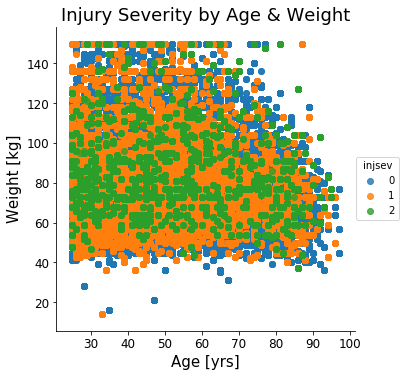

In [426]:
sns.lmplot('age', 'weight',fatal_nona[fatal_nona['age']>24], hue='injsev', fit_reg=False )
plt.xlabel('Age [yrs]', fontsize=15)
plt.ylabel('Weight [kg]', fontsize=15)
plt.title('Injury Severity by Age & Weight', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

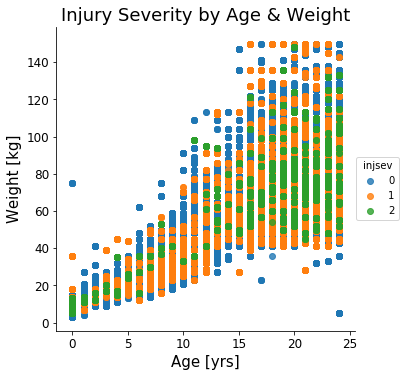

In [142]:
sns.lmplot('age', 'weight',fatal_nona[fatal_nona['age']<=24], hue='injsev', fit_reg=False )
plt.xlabel('Age [yrs]', fontsize=15)
plt.ylabel('Weight [kg]', fontsize=15)
plt.title('Injury Severity by Age & Weight', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


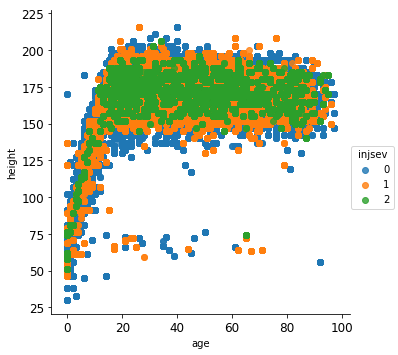

In [416]:
sns.lmplot('age','height' ,fatal_nona, hue='injsev', fit_reg=False )
# plt.ylabel('Delta Velocity [kmph]', fontsize=15)
# plt.xlabel('Weight [kg]', fontsize=15)
# plt.title('Injury Severity by Weight & Height', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [459]:
fatal_nona[ fatal_nona['seatpos'].isin([21,22,23]) ]['manuse'].value_counts()

4     65392
0     36987
14    31325
3      6251
13     5309
15      216
8        96
1        52
18       16
12       10
5         4
Name: manuse, dtype: int64

## Modeling I Decision Tree with Variable Encoding
- Need to OneHotEncode or pd.get_dummies on the categorical columns

In [93]:
encode_columns = ['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex']

continuous_columns = ['dof1','dvest','dvtotal','age','height','weight',
                     'gad1_B', 'gad1_F','gad1_L', 'gad1_R', 'gad1_T', 'gad1_U']

In [94]:
fatal_nona[encode_columns].nunique()

year        12
bodytype    30
dvbasis      3
make        49
modelyr     58
bagdeply     4
bagfail      2
chtype       7
manfail      9
manuse      12
role         2
seatpos     23
sex          6
dtype: int64

In [95]:
# Converting the features to encode with pd.get_dummies into a string
X_dummie_columns = fatal_nona[encode_columns].astype('str')

In [96]:
# Joining the the get dummies columns witht the DataFrame before createing Test/Train split
fatal_nona_two = pd.concat([fatal_nona,pd.get_dummies(X_dummie_columns)], axis=1)

In [97]:
fatal_nona_two.to_csv('fatality_facts_nona_two.csv')

In [185]:
# X features dropping the target and all features that get dummies were performed on
y = fatal_nona_two['injsev']
X = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [186]:
# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona['injsev'])

In [189]:
dt = DecisionTreeClassifier(min_samples_leaf=10)
s = cross_val_score(dt, X_train, y_train, cv=5, n_jobs=2)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.963 ± 0.001


In [190]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [191]:
feature_import = pd.concat([pd.Series(X_train.columns),
                            pd.Series(dt.feature_importances_.tolist())],
                           axis=1).sort_values(1,ascending=False)
feature_import.reset_index(level=0, drop=True, inplace=True)
feature_import.columns = ['feature','importance']

In [192]:
feature_import.set_index('feature', inplace=True)

Text(0.5,0,'Features')

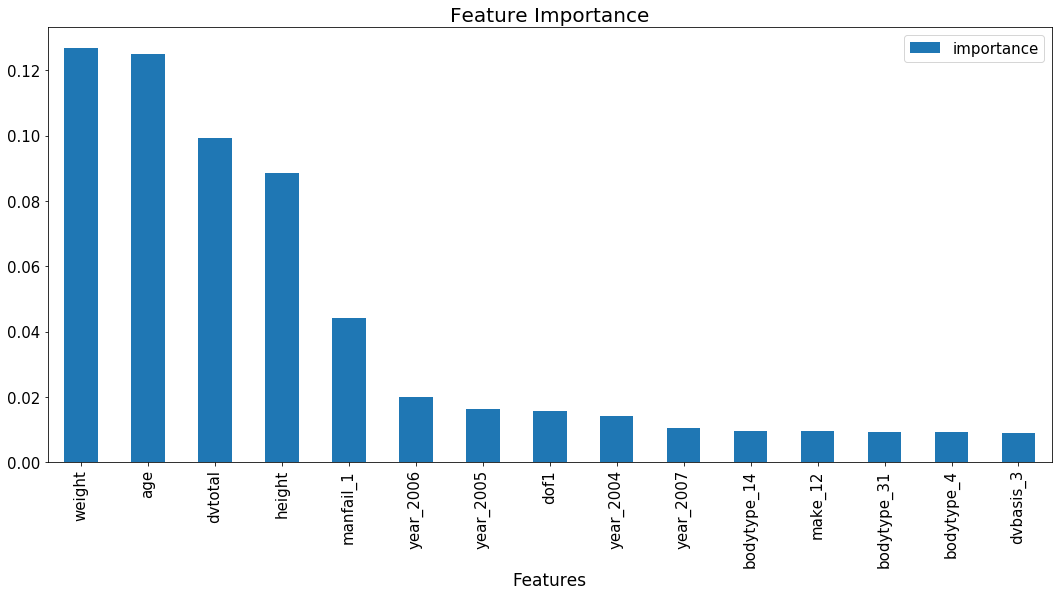

In [200]:
# Plotting the feature importances
plt.figure(figsize=(20,13))
feature_import.iloc[:15].plot(kind='bar', 
                    fontsize=15, figsize=(18,8))
plt.legend(fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=17)

In [201]:
# Setting up y_true and y_pred variable to compose the confusion matrix
y_true = y_test.copy()
y_pred = dt.predict(X_test)

confusion = pd.crosstab(y_true, y_pred)
confusion.columns = ['Unsevere','Severe','Fatal']
confusion

,Unsevere,Severe,Fatal
injsev,,,
0,155487,2235,237
1,2978,46694,161
2,261,192,5730


In [202]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98    157959
          1       0.95      0.94      0.94     49833
          2       0.94      0.93      0.93      6183

avg / total       0.97      0.97      0.97    213975



### BEST ---- Modeling III (removing weight due to mix of kg and lbs units) ---- BEST

In [484]:
# X features dropping the target and all features that get dummies were performed on
y = fatal_nona_two['injsev']
X = fatal_nona_two.copy().drop(['weight','year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [485]:
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2]) # 3 class output
n_classes = y.shape[1] # shape = (1069871, 3)

# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona['injsev'])

dt = DecisionTreeClassifier(min_samples_leaf=10)
classifier = OneVsRestClassifier(dt.fit(X_train, y_train))
y_score = classifier.fit(X_train, y_train).predict(X_test)

In [486]:
# Compute ROC curve and ROC area for each class
fpr = {}  # false-positive rate
tpr = {}  # true-positive rate
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

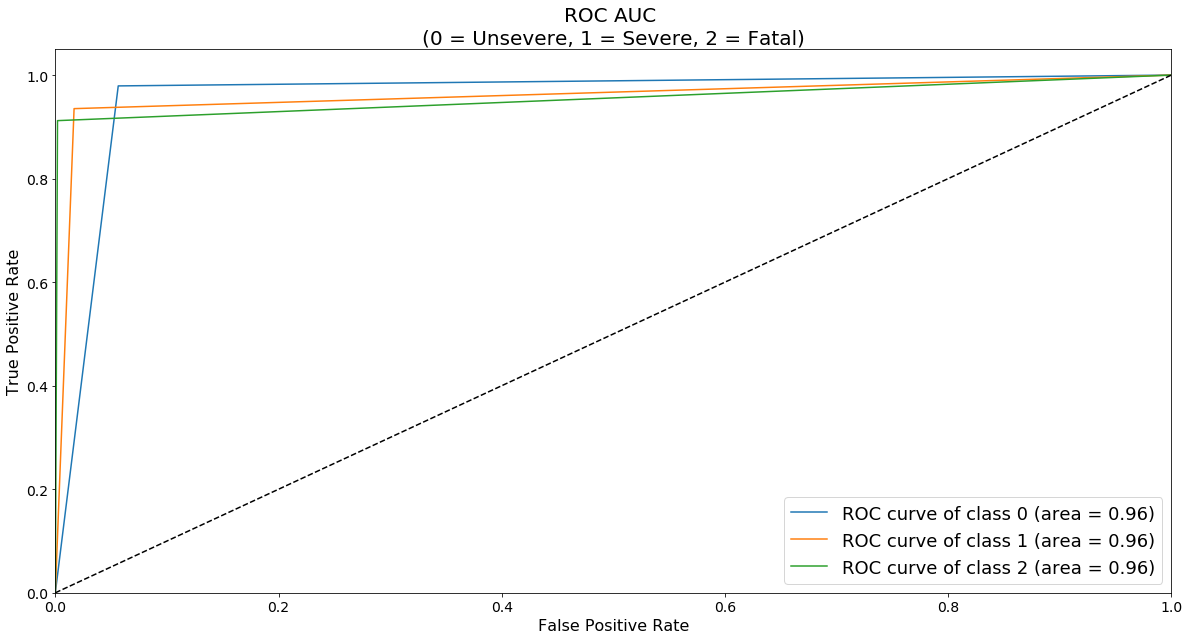

In [487]:
# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
plt.figure(figsize=(20,10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC AUC \n(0 = Unsevere, 1 = Severe, 2 = Fatal)', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.show()

In [574]:
s = cross_val_score(dt, X_test, y_test, cv=5, n_jobs=2, scoring='precision')
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

KeyboardInterrupt: 

Text(0.5,0,'Features')

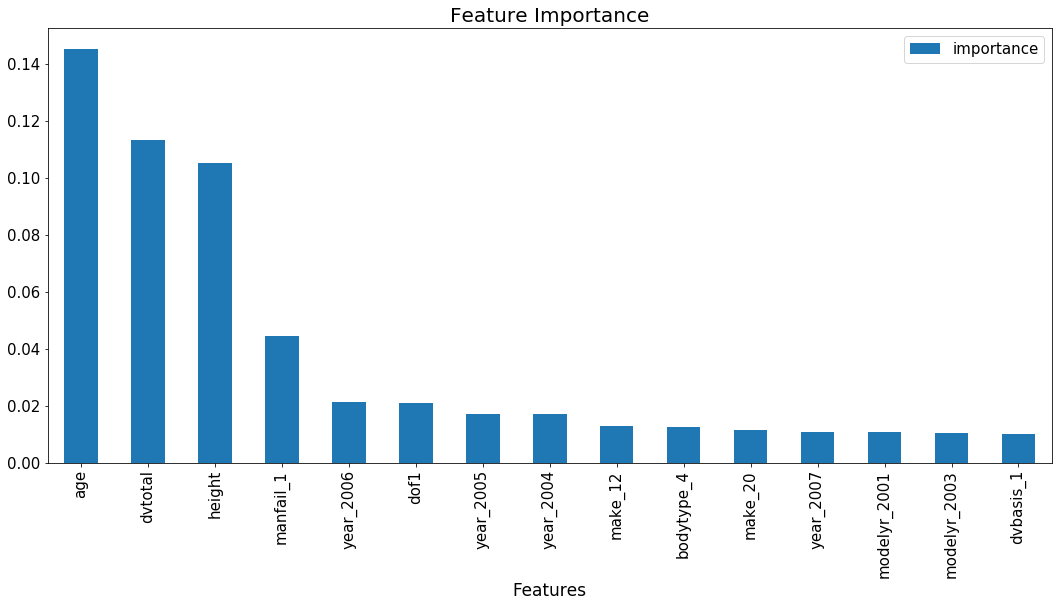

In [471]:
feature_import = pd.concat([pd.Series(X_train.columns),
                            pd.Series(dt.feature_importances_.tolist())],
                           axis=1).sort_values(1,ascending=False)
feature_import.reset_index(level=0, drop=True, inplace=True)
feature_import.columns = ['feature','importance']

feature_import.set_index('feature', inplace=True)

# Plotting the feature importances
plt.figure(figsize=(20,13))
feature_import.iloc[:15].plot(kind='bar', 
                    fontsize=15, figsize=(18,8))
plt.legend(fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=17)

In [480]:
# Setting up y_true and y_pred variable to compose the confusion matrix
y_true = y_test.copy()
y_pred = dt.predict(X_test)

confusion = pd.crosstab(y_true, y_pred)
confusion.columns = ['Unsevere','Severe','Fatal']
confusion

,Unsevere,Severe,Fatal
injsev,,,
0,155203,2532,224
1,3349,46314,170
2,310,272,5601


In [481]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98    157959
          1       0.94      0.93      0.94     49833
          2       0.93      0.91      0.92      6183

avg / total       0.97      0.97      0.97    213975



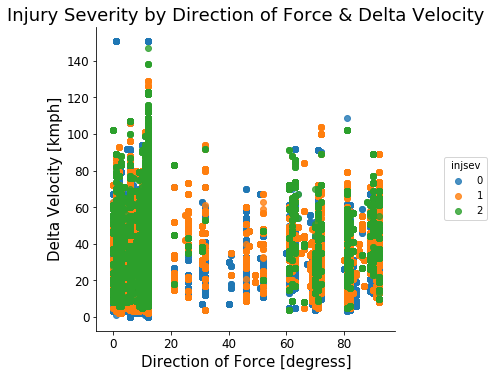

In [552]:
# Direction of Highest Force vs Relative velocity
sns.lmplot('dof1', 'dvtotal',fatal_nona_two, hue='injsev', fit_reg=False )
plt.xlabel('Direction of Force [degress]', fontsize=15)
plt.ylabel('Delta Velocity [kmph]', fontsize=15)
plt.title('Injury Severity by Direction of Force & Delta Velocity', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

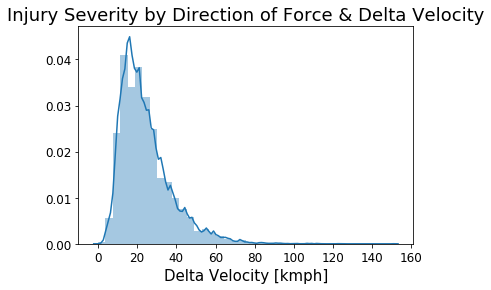

In [566]:
sns.distplot(fatal_nona_two['dvtotal'],hist=True, bins=40)
plt.xlabel('Delta Velocity [kmph]', fontsize=15)
plt.ylabel('', fontsize=15)
plt.title('Injury Severity by Direction of Force & Delta Velocity', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

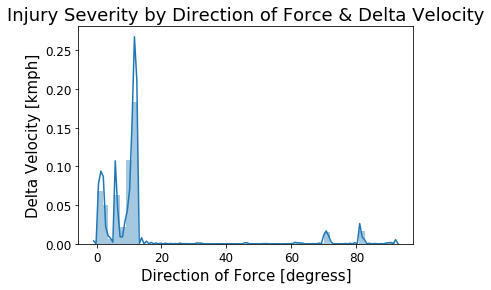

In [572]:
sns.distplot(fatal_nona_two['dof1'],hist=True, )
plt.xlabel('Direction of Force [degress]', fontsize=15)
plt.ylabel('Delta Velocity [kmph]', fontsize=15)
plt.title('Injury Severity by Direction of Force & Delta Velocity', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

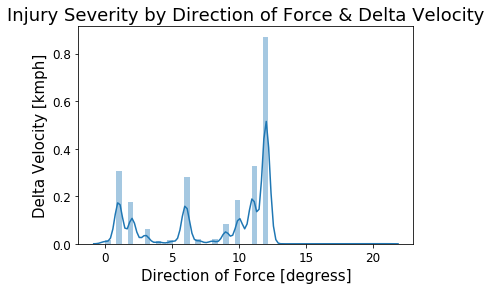

In [571]:
sns.distplot(fatal_nona_two[fatal_nona_two['dof1']<25]['dof1'],hist=True, )
plt.xlabel('Direction of Force [degress]', fontsize=15)
plt.ylabel('Delta Velocity [kmph]', fontsize=15)
plt.title('Injury Severity by Direction of Force & Delta Velocity', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Modeling IV Decision Tree with Variable Encoding and OneVsRest ROC AUC

In [438]:
# X features dropping the target and all features that get dummies were performed on
y = fatal_nona_two['injsev']
X = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [439]:
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2]) # 3 class output
n_classes = y.shape[1] # shape = (1069871, 3)

# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona['injsev'])

classifier = OneVsRestClassifier(dt.fit(X_train, y_train))
y_score = classifier.fit(X_train, y_train).predict(X_test)

In [440]:
X.shape

(1069871, 229)

In [441]:
X_train.shape

(855896, 229)

In [442]:
# Compute ROC curve and ROC area for each class
fpr = {}  # false-positive rate
tpr = {}  # true-positive rate
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

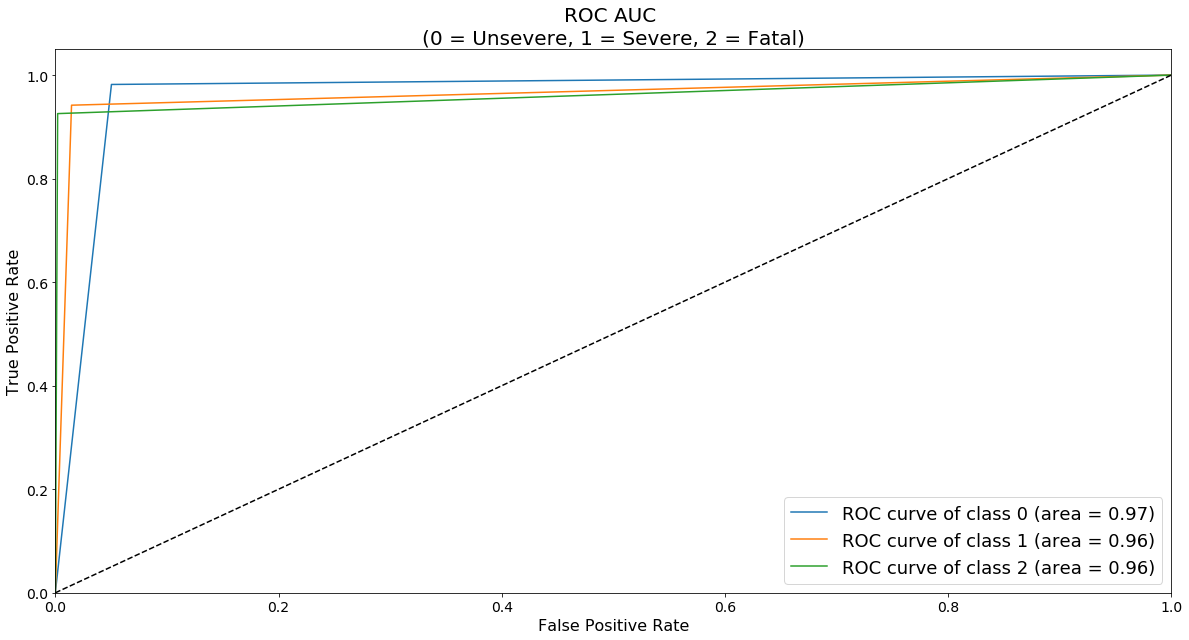

In [443]:
# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
plt.figure(figsize=(20,10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC AUC \n(0 = Unsevere, 1 = Severe, 2 = Fatal)', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.show()

In [496]:
# Setting up y_true and y_pred variable to compose the confusion matrix
y_true = y_test.copy()
y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred))
print()
# print(y_true)
# print(y_pred)
# confusion = pd.crosstab(y_true, y_pred)
# confusion.columns = ['Unsevere','Severe','Fatal']
# confusion
y_pred
# confusion_matrix(y_true, y_pred)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [259]:
# Classification Report
y_true = y_test.copy()
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98    157959
          1       0.95      0.94      0.94     49833
          2       0.94      0.92      0.93      6183

avg / total       0.97      0.97      0.97    213975



Text(0.5,0,'Features')

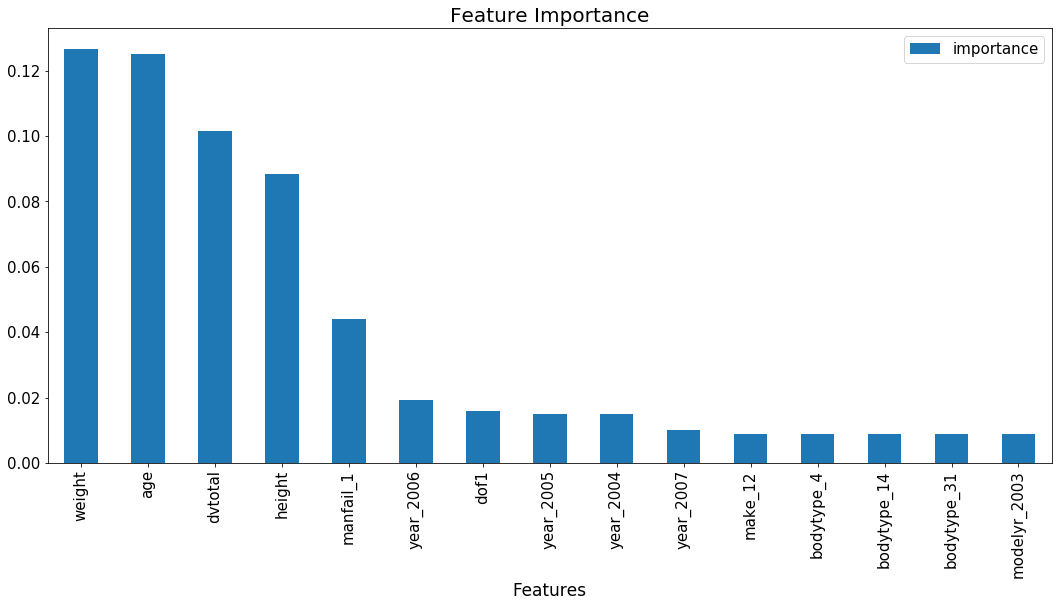

In [264]:
feature_import = pd.concat([pd.Series(X_train.columns),
                            pd.Series(dt.feature_importances_.tolist())],
                           axis=1).sort_values(1,ascending=False)
feature_import.reset_index(level=0, drop=True, inplace=True)
feature_import.columns = ['feature','importance']

feature_import.set_index('feature', inplace=True)

# Plotting the feature importances
plt.figure(figsize=(20,13))
feature_import.iloc[:15].plot(kind='bar', 
                    fontsize=15, figsize=(18,8))
plt.legend(fontsize=15)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=17)

In [462]:
fatal_nona_two['manfail'].value_counts()

1    859843
0    208375
3       633
2       456
6       204
7       170
5       104
8        72
4        14
Name: manfail, dtype: int64

In [465]:
fatal_nona_two['year'].value_counts()

2004    258617
2006    231775
2005    222090
2007    103224
2008     77596
2009     49706
2010     37825
2011     35255
2014     24737
2012     20102
2013      4870
2015      4074
Name: year, dtype: int64

In [466]:
fatal_nona_two['bodytype'].value_counts()

4     461313
14    165693
2      85404
31     82634
20     68503
30     55362
15     41515
3      27725
6      23349
21     18006
5      16007
1      11534
16      9395
40       972
28       786
9        386
39       348
17       342
25       128
32        84
19        71
24        68
10        65
29        42
7         39
22        33
12        24
8         18
33        15
41        10
Name: bodytype, dtype: int64

## Model IV: Logistic Regression Multiclassification

### PCA

In [387]:
y = fatal_nona_two['injsev']
X = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [391]:

scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=X.shape[1]))
pipe = Pipeline([scaling, pca])

Xt = pipe.fit_transform(X)

In [406]:
print(fatal_nona_two.shape)
print(Xt.shape)

(1069871, 244)
(1069871, 229)


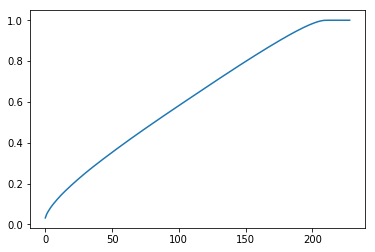

In [392]:
var_exp = pipe.named_steps['pca'].explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
plt.plot(range(len(cum_var_exp)), cum_var_exp)

In [393]:
# Constructed DataFrame of PCA's
features_pca = ['PC'+str(i+1) for i in range(pipe.named_steps['pca'].n_components_)]

features = X.columns

pca_components = pd.DataFrame(pipe.named_steps['pca'].components_.T, columns=features_pca, index=features)

In [394]:
pca_components[['PC1','PC2','PC3','PC4']].sort_values(by='PC1', ascending=False).head(10)

,PC1,PC2,PC3,PC4
bagdeply_0,0.298762,0.092114,0.018335,-0.267877
bagfail_0,0.286629,0.105780,0.021397,-0.293352
role_1,0.271028,-0.075787,-0.374150,0.047367
manuse_14,0.216643,-0.169290,0.264800,0.126211
seatpos_21,0.166048,-0.044006,0.027237,-0.031713
seatpos_23,0.165439,-0.027348,-0.013262,-0.037938
chtype_3,0.136696,-0.095290,0.169101,0.081164
chtype_4,0.127257,-0.096938,0.148495,0.073499
seatpos_22,0.122136,-0.024477,0.068885,0.006515
manuse_13,0.094839,-0.067376,0.124903,0.043945


In [395]:
pca_components[['PC1','PC2','PC3','PC4']].sort_values(by='PC2', ascending=False).head(10)

,PC1,PC2,PC3,PC4
manfail_0,0.090870,0.438432,0.004151,0.227316
manuse_0,0.090807,0.438203,0.003964,0.227498
height,-0.259070,0.182440,-0.152712,-0.177243
chtype_0,-0.246423,0.177302,-0.298909,-0.149428
weight,-0.218767,0.167949,-0.065028,-0.144148
sex_1,-0.012321,0.131795,0.108412,-0.277795
bagfail_0,0.286629,0.105780,0.021397,-0.293352
dvtotal,0.012309,0.097427,0.029301,0.024093
bagdeply_0,0.298762,0.092114,0.018335,-0.267877
role_0,-0.271028,0.075787,0.374150,-0.047367


In [396]:
pca_components[['PC1','PC2','PC3','PC4']].sort_values(by='PC3', ascending=False).head(10)

,PC1,PC2,PC3,PC4
seatpos_11,-0.270999,0.075774,0.374197,-0.047323
role_0,-0.271028,0.075787,0.374150,-0.047367
manuse_14,0.216643,-0.169290,0.264800,0.126211
chtype_3,0.136696,-0.095290,0.169101,0.081164
chtype_4,0.127257,-0.096938,0.148495,0.073499
manuse_13,0.094839,-0.067376,0.124903,0.043945
chtype_1,0.092117,-0.059340,0.113376,0.070524
sex_1,-0.012321,0.131795,0.108412,-0.277795
chtype_2,0.088400,-0.064794,0.105961,0.043257
chtype_8,0.082930,-0.061233,0.105556,0.037736


/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning:

The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.



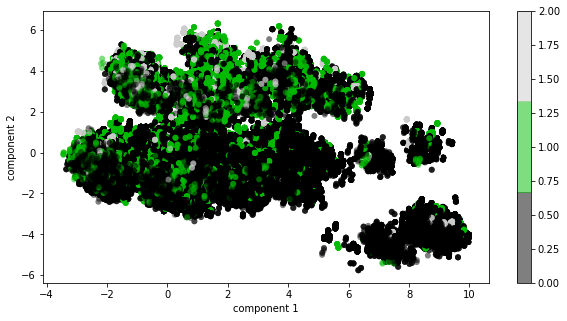

In [412]:
plt.figure(figsize=(10,5))
plt.scatter(Xt[:, 0], Xt[:, 1],
            c=fatal_nona_two['injsev'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning:

The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.



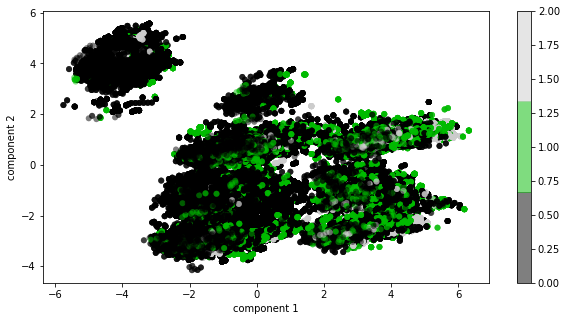

In [413]:
plt.figure(figsize=(10,5))
plt.scatter(Xt[:, 1], Xt[:, 2],
            c=fatal_nona_two['injsev'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [ ]:
features = X.columns
X_pca = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)
y_pca = fatal_nona_two['injsev']

for features_2 in combinations(features, 10):
    X_pca = fatal_nona_two[list(features_2)]
    ss = StandardScaler()
    Xs = ss.fit_transform(X_pca)
    logreg = LogisticRegression(multi_class='multinomial', solver='sag')
    print(features_2, cross_val_score(logreg, Xs, y_pca, cv=5).mean())

In [296]:
# X features dropping the target and all features that get dummies were performed on
y = fatal_nona_two['injsev']
X = fatal_nona_two.copy().drop(['year', 'bodytype','dvbasis','make','modelyr',
                   'bagdeply', 'bagfail', 'chtype','manfail','manuse', 
                   'role', 'seatpos', 'sex','injsev','gad1'], axis=1)

In [299]:
# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona['injsev'])

In [306]:
# mul_lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')
# mul_lr.fit(X_train, y_train)

In [ ]:

def build_tree_models(x, y, tree_depth_range=range(1,11), min_leaf):
    tree_model_ypreds = {}
    
    for i in tree_depth_range:
        model = DecisionTreeRegressor(max_depth=i, min_samples_leaf=min_leaf)
        model.fit(x[:, np.newaxis], y)
        tree_model_ypreds[i] = model.predict(x[:, np.newaxis])
        
    return tree_model_ypreds

In [451]:
def mph(kmph):
    '''
    Function to convert kmph to mph.  
    Enter the speed in kmph and the function converts it to mph.
    - default set to 0.0001
    '''
    return (0.621371*kmph)

In [ ]:
plt.figure(figsize=(20,13))
mask = np.zeros_like(X_train.corr()[X_train.corr()>0.20])
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(X_train.corr()[X_train.corr()>0.20], mask=mask, vmax=.3, annot=True, square=True)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Features Correlations', fontsize = 25)
plt.show()


In [452]:
for i in range(148):
    print('kmph = {} mph = {}'.format(i, mph(i)))

kmph = 0 mph = 0.0
kmph = 1 mph = 0.621371
kmph = 2 mph = 1.242742
kmph = 3 mph = 1.8641130000000001
kmph = 4 mph = 2.485484
kmph = 5 mph = 3.106855
kmph = 6 mph = 3.7282260000000003
kmph = 7 mph = 4.349597
kmph = 8 mph = 4.970968
kmph = 9 mph = 5.592339
kmph = 10 mph = 6.21371
kmph = 11 mph = 6.835081
kmph = 12 mph = 7.4564520000000005
kmph = 13 mph = 8.077823
kmph = 14 mph = 8.699194
kmph = 15 mph = 9.320565
kmph = 16 mph = 9.941936
kmph = 17 mph = 10.563307
kmph = 18 mph = 11.184678
kmph = 19 mph = 11.806049
kmph = 20 mph = 12.42742
kmph = 21 mph = 13.048791
kmph = 22 mph = 13.670162
kmph = 23 mph = 14.291533
kmph = 24 mph = 14.912904000000001
kmph = 25 mph = 15.534275000000001
kmph = 26 mph = 16.155646
kmph = 27 mph = 16.777017
kmph = 28 mph = 17.398388
kmph = 29 mph = 18.019759
kmph = 30 mph = 18.64113
kmph = 31 mph = 19.262501
kmph = 32 mph = 19.883872
kmph = 33 mph = 20.505243
kmph = 34 mph = 21.126614
kmph = 35 mph = 21.747985
kmph = 36 mph = 22.369356
kmph = 37 mph = 22.990727